In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.optimize as opt
import scipy.signal as scisig

In [24]:
import scipy 
from scipy.signal import butter, lfilter

def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='lowpass')
    return b, a


def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='highpass')
    return b, a


def butter_highpass_filter(data, lowcut, fs, order=5):
    b, a = butter_highpass(lowcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def charge_from_tt(signal, centre_freq, time):
    filt = butter_lowpass_filter(signal, centre_freq+10000, fs = 10**6, order=5)
    filtfilt = butter_highpass_filter(filt, centre_freq-10000, fs = 10**6, order=5)
    X = filtfilt*np.cos(centre_freq*time)
    Y = filtfilt*np.sin(centre_freq*time)
    theta = -np.arctan(Y/X)
    theta_filt = butter_lowpass_filter(theta, 10, fs = 10**6, order=2)
    return theta, theta_filt

def charge_from_tt2(signal, drive, centre_freq):
    filt = butter_lowpass_filter(signal, centre_freq+1000, fs = 10**6, order=5)
    filtfilt = butter_highpass_filter(filt, centre_freq-1000, fs = 10**6, order=5)
    fftsig = scipy.fft.rfft(filtfilt)
    fftdrive = scipy.fft.rfft(drive)
    corr = fftsig*np.conjugate(fftdrive)
    charge = max(corr, key = abs)
    return charge

In [282]:
filename = 'D:\\Experiment\\Cooling\\230526\\Cooling z\\tt4.mat'
data = sio.loadmat(filename)
tt = np.transpose(data['C'])[0]
fs = 1/data['Tinterval'][0][0]
PSD = scisig.welch(tt, fs, nperseg = 10**4)


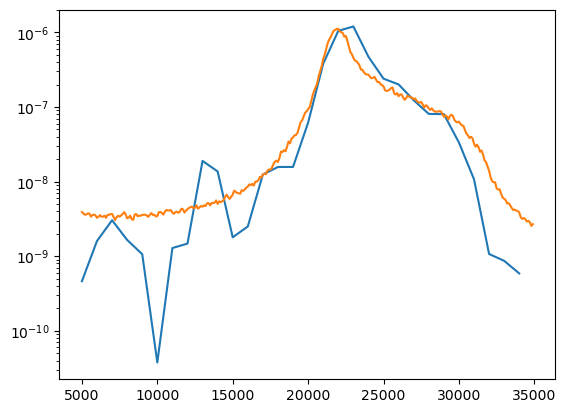

In [283]:
PSD1 = scisig.welch(tt[:1*10**3], fs, nperseg = 10**3)

lb = int(0.001*5000)
ub = int(0.001*35000)
plt.plot(PSD1[0][lb:ub], PSD1[1][lb:ub])

lb = int(0.01*5000)
ub = int(0.01*35000)
plt.plot(PSD[0][lb:ub], PSD[1][lb:ub])
plt.yscale('log')

Text(0.5, 0, 'Frequency (Hz)')

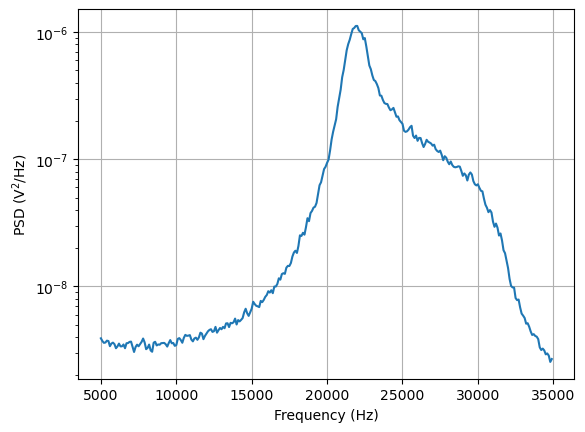

In [284]:
plt.figure()
plt.grid()
lb = int(0.01*5000)
ub = int(0.01*35000)
plt.plot(PSD[0][lb:ub], PSD[1][lb:ub])
plt.yscale('log')
plt.ylabel('PSD (V$^2$/Hz)')
plt.xlabel('Frequency (Hz)')

In [285]:
time = np.linspace(0, 2, len(tt))

In [286]:
theta, theta_filt = charge_from_tt(tt, 20000, time)

In [287]:
theta = np.unwrap(theta, period = np.pi)

In [55]:
freq = (theta[1:] - theta[:-1])*fs/2/np.pi

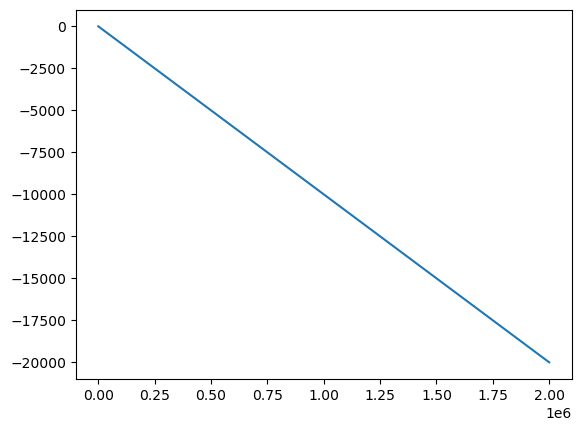

In [59]:
plt.plot(theta)

In [ ]:
def demod_RTheta2(filename, demod_freq, bandwidth, bw2, bw3):
t2, X_tt, Y_tt = demod_XY2(filename, demod_freq)
X_tt_filt = butter_lowpass_filter(X_tt, bandwidth, int(1/t2[1]), order = 5)
Y_tt_filt = butter_lowpass_filter(Y_tt, bandwidth, int(1/t2[1]), order = 5)
R2 = X_tt_filt**2 + Y_tt_filt**2
theta = np.unwrap(-2*np.arctan(X_tt_filt[1:]/Y_tt_filt[1:]))/2
R2_filt = butter_lowpass_filter(R2, bw2, int(1/t2[1]), order = 2)
theta_filt = butter_lowpass_filter(theta, bw3, int(1/t2[1]), order = 2)
return t2, R2_filt, theta_filt, R2

def demod_XY2(filename, demod_freq):
tt = sio.loadmat(filename)
signal_tt = tt['z'][0]#*calyz
#signal_tt = np.transpose(tt['B'])[0]
t2 = np.transpose(tt['time'])[0][:-1]
#t2 = np.linspace(0, len(np.transpose(tt['B'])[0])tt['Tinterval'][0][0], len(np.transpose(tt['B'])[0]))
demod = np.cos(2np.pi*demod_freq*np.array(t2))
demod2 = np.sin(2*np.pi*demod_freq*np.array(t2))
X_tt = signal_tt*demod
Y_tt = signal_tt*demod2
return t2, X_tt, Y_tt

In [295]:
centre_freq = 22300
X = tt*np.cos(2*np.pi*centre_freq*time)
Y = tt*np.sin(2*np.pi*centre_freq*time)
X_f = butter_lowpass_filter(X, 8000, 10**6, order = 5)
Y_f = butter_lowpass_filter(Y, 8000, 10**6, order = 5)
theta = np.unwrap(-2*np.arctan2(Y_f,X_f))/2
theta_filt = butter_lowpass_filter(theta, 10000, fs = 10**6, order=2)

In [296]:
PSD = scisig.welch(tt, fs, nperseg = 10**5)
PSDX = scisig.welch(X, fs, nperseg = 10**5)
PSDX_f = scisig.welch(X_f, fs, nperseg = 10**5)

Text(0.5, 0, 'Frequency (Hz)')

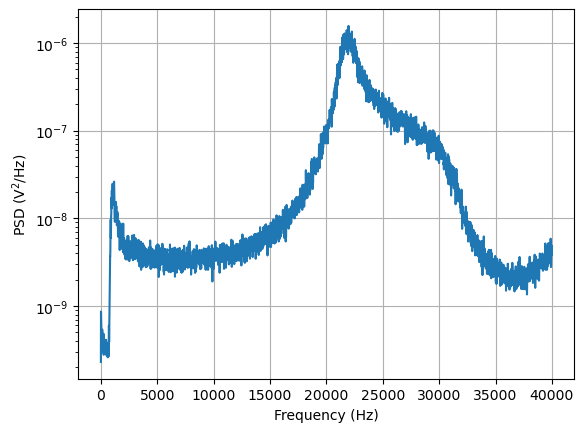

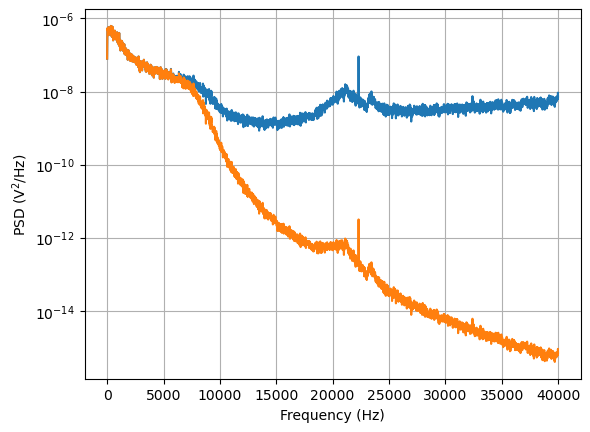

In [297]:
plt.figure()
plt.grid()
lb = int(0.0)
ub = int(0.1*40000)
plt.plot(PSD[0][lb:ub], PSD[1][lb:ub])
plt.yscale('log')
plt.ylabel('PSD (V$^2$/Hz)')
plt.xlabel('Frequency (Hz)')
plt.figure()
plt.grid()
lb = int(0)
ub = int(0.1*40000)
plt.plot(PSDX[0][lb:ub], PSDX[1][lb:ub])
plt.plot(PSDX_f[0][lb:ub], PSDX_f[1][lb:ub])
plt.yscale('log')
plt.ylabel('PSD (V$^2$/Hz)')
plt.xlabel('Frequency (Hz)')

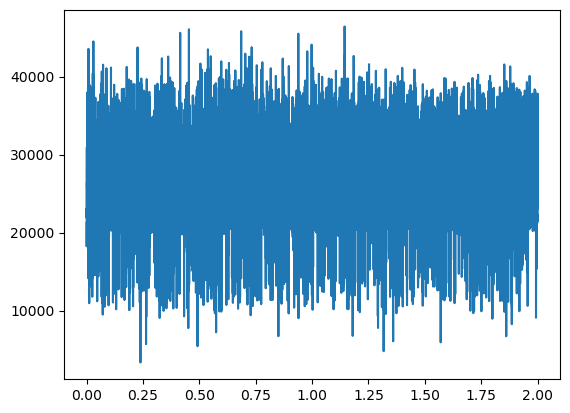

In [298]:
#plt.plot(time[11:10000], np.diff(theta[10:10000])*fs/2/np.pi+22300)
plt.plot(time[11:], np.diff(theta_filt[10:])*fs/2/np.pi+22300)

In [299]:
tt_con = np.sin((np.diff(theta_filt[10:])*fs)*time[11:])
PSD_con = scisig.welch(tt_con, fs, nperseg = 10**3)

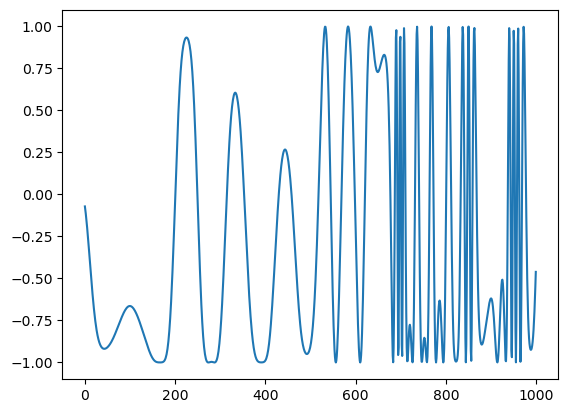

In [300]:
plt.plot(tt_con[:1000])

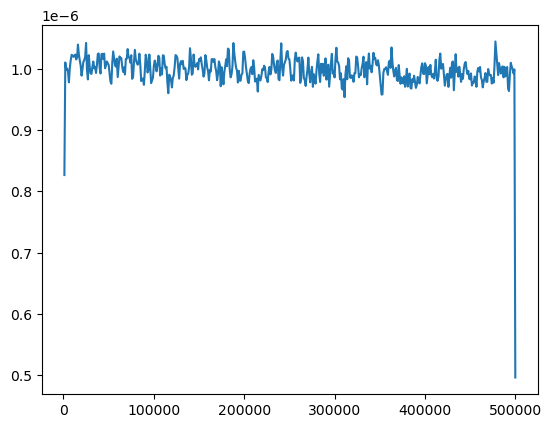

In [301]:
lb = 1
ub = 1000
plt.plot(PSD_con[0][lb:ub], PSD_con[1][lb:ub])